In this kernel i will be performing sentiment prediction for 'Corona Tweets'  using bi-directional LSTM. The kernel will be having these section and will be explaining it as you scroll

*   Importing the required library's
*   Cleaning the data
  *   Converting the text to lower case
  *   Removing URL's
  *   Removing stop words
  *   Removing punctuation's

*   Preparing the text and building the model
  *   Tokenizing the text
  *   Converting the texts to sequences
  *   Padding the sequence
  *   Building the model & model summary
  *   Training the model

*   Predicting on test data and calculating accuracy score and plotting confusion matrix







<h3>Importing required library's</h3>

In [62]:
import os
import pandas as pd
import re
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
import tensorflow.keras.layers as L
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
import nltk
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
from string import punctuation
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [63]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [64]:
os.chdir("/content/drive/My Drive/Python/Practice/Corona NLP")

In [65]:
ls

 Corona_NLP_test.csv   'Corona Text Classification.ipynb'
 Corona_NLP_train.csv  'Corona tweet sentiment prediction .ipynb'


In [66]:
df = pd.read_csv("Corona_NLP_train.csv",encoding="latin-1")

In [67]:
test_data = pd.read_csv("Corona_NLP_test.csv")

In [68]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [69]:
df['Sentiment'].value_counts()

Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

Since we have unique values like 'Positive' , 'Negative' , 'Neutral' , 'Extremely Positive' , ' Extremely Negative' we will just convert them to 'Positive' , 'Negative, 'Neutral' with it's corresponding integer value

In [70]:
def encode_sentiment(sentiment):
  if sentiment=="Neutral":
    return 0
  elif sentiment=="Positive":
    return 2
  elif sentiment=="Negative":
    return 1
  elif sentiment=="Extremely Positive":
    return 2
  elif sentiment=="Extremely Negative":
    return 1

Creating a new column called 'new_sentiment' and applying the 'encode_sentiment' function to the 'sentiment' column which results in encoding the values to an integer

In [71]:
df['new_sentiment'] = df['Sentiment'].apply(encode_sentiment)

In [72]:
df['new_sentiment'].value_counts()

2    18046
1    15398
0     7713
Name: new_sentiment, dtype: int64

In [23]:
train_df = df[['OriginalTweet','new_sentiment']]

In [24]:
train_df.head()

,OriginalTweet,new_sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,0
1,advice Talk to your neighbours family to excha...,2
2,Coronavirus Australia: Woolworths to give elde...,2
3,My food stock is not the only one which is emp...,2
4,"Me, ready to go at supermarket during the #COV...",1


In [25]:
train_df = train_df.sample(frac=1)

In [26]:
sentiment = train_df['new_sentiment'].values

<H3>Preprocessing Text</h3>

For Preprocessing we will , 
*   Convert the text to string
*   Lower the string
*   Create a Regular Expression to remove any URL's
*   Removing punctuation
*   Removing any special characters
*   Remove stopwords





In [27]:
def process_text(text):
  text = str(text) #Convert string to str
  #Lowers the string
  text = text.lower()
  #Removes the full url
  url_remove = re.compile(r'(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?')
  text = re.sub(url_remove,' ',text)
  #Removes the punctuation
  text = ''.join([string for string in text if string not in punctuation and not string.isdigit()])
  #Removes any more special characters
  special_character = re.compile(r'[^a-zA-Z]')
  text = re.sub(special_character,' ', text)
  text = text.strip() #Strip white spaces
  text = text.split(' ')
  text = ' '.join([string for string in text if string not in stopwords.words('english')])#Removing all stop words
  return text

In [28]:
train_df['processed_tweet'] = train_df['OriginalTweet'].apply(process_text)

In [29]:
train_df.head()

,OriginalTweet,new_sentiment,processed_tweet
4666,#WhatAreThoseWednesday When thereÂs no meat a...,1,whatarethosewednesday meat grocery store impr...
39842,#Import #PP prices in #Turkey were on a downtr...,1,import pp prices turkey downtrend since late f...
776,Stop panic buying. It is consider mass gatheri...,1,stop panic buying consider mass gathering well...
27020,#Coronavirus killed the #OilDeal. There is a h...,1,coronavirus killed oildeal huge possibility ne...
19986,your scared to catch #HIV &amp; you will use a...,1,scared catch hiv amp use protections amp preca...


<h3>Tokenizing text</h3>

In [31]:
tokenizer = Tokenizer()

In [32]:
tokenizer.fit_on_texts(train_df['processed_tweet'].values)

In [34]:
train =  tokenizer.texts_to_sequences(train_df['processed_tweet'].values)

Padding post the text with '0' so they all be of same length

In [35]:
train = pad_sequences(train,padding='post')

In [37]:
x_train , x_test , y_train , y_test = train_test_split(train,sentiment,test_size=0.2,random_state=42)

<h3>Building the Model</h3>

In [39]:
embedding_vectors = 30
VOCAB_SIZE = len(tokenizer.word_index)+1

In [73]:
model = tf.keras.Sequential([
    L.Embedding(VOCAB_SIZE,embedding_vectors, input_length=x_train.shape[1]),
    L.Bidirectional(L.LSTM(256,return_sequences=True)),
    L.GlobalMaxPool1D(),
    L.Dropout(0.4),
    L.Dense(256, activation="relu"),
    L.Dropout(0.4),
    L.Dense(3)
])

In [41]:
model.compile(loss=SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',metrics=['accuracy']
             )

In [42]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 46, 30)            1709340   
_________________________________________________________________
bidirectional (Bidirectional (None, 46, 512)           587776    
_________________________________________________________________
global_max_pooling1d (Global (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 7

<h3>Training the data</h3>

In [43]:
model.fit(x_train,y_train,epochs=2,
          validation_data=(x_test,y_test))

Epoch 1/2
1029/1029 [==============================] - 300s 291ms/step - loss: 0.6444 - accuracy: 0.7287 - val_loss: 0.4674 - val_accuracy: 0.8341
Epoch 2/2
1029/1029 [==============================] - 297s 289ms/step - loss: 0.3365 - accuracy: 0.8883 - val_loss: 0.4457 - val_accuracy: 0.8482


<h3>Making predictions on test data</h3>

In [44]:
test = test_data[['OriginalTweet','Sentiment']]

In [45]:
test['processed_tweet'] = test_data['OriginalTweet'].apply(process_text)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [46]:
test['new_sentiment'] = test_data['Sentiment'].apply(encode_sentiment)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [47]:
test.drop(['OriginalTweet','Sentiment'],inplace=True,axis=1)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [48]:
test.head()

,processed_tweet,new_sentiment
0,trending new yorkers encounter empty supermark...,1
1,couldnt find hand sanitizer fred meyer turned ...,2
2,find protect loved ones coronavirus,2
3,panic buying hits newyork city anxious shopper...,1
4,toiletpaper dunnypaper coronavirus coronavirus...,0


In [49]:
test_tweet = test['processed_tweet'].values
test_sentiment = test['new_sentiment'].values

In [50]:
convert_seq = tokenizer.texts_to_sequences(test_tweet)

In [51]:
convert_seq = pad_sequences(convert_seq,padding='post')

<h3>Making predictions on test data</h3>

In [53]:
predict = model.predict_classes(convert_seq)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [54]:
print(f"The accuracy is : { accuracy_score(test_sentiment,predict)*100}%")

The accuracy is : 82.06951026856241%


<h3>Confusion Matrix</h3>

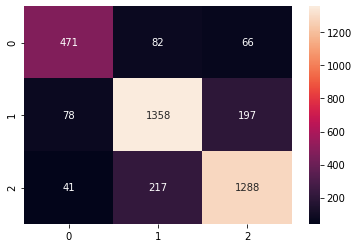

In [61]:
sns.heatmap(confusion_matrix(test_sentiment,predict),annot=True, fmt="d")

Where,
*   0 - Neutral
*   1 - Negative
*   2 - Positive


